# Workflow described in MICCAI-STACOM 2023 conference paper 'Automated quality-controlled left heart segmentation from 2D echocardiography'. 

This notebook provides a workflow to automatically compute currently relevant clinical indices using the segmentations of the left ventricular cavity (LV<sub>cav</sub>), myocardium (LV<sub>myo</sub>), and left atrium (LA) from 2D echocardiography. Two separate quality control (QC) steps are incorporated to (1) select frames for post-processing and (2) select erroneous or temporally inconsistent segmentations. These quality steps are described in more detail in the paper. 

>It is assumed that the segmentation will consist of all three structures, with the following labels: <br>
> * 0: background <sub>  </sub>
> * 1: LV<sub>cav</sub>
> * 2: LV<sub>myo</sub>
> * 3: LA <sub>  </sub>
 
**Includes:** 
* [Define parameters and paths to data](#define-parameters-and-paths-to-data)
* [Get image acquisition properties from DICOM files](#retrieve-image-acquisition-properties-from-dicom-files) 
* [Get image and segmentation parameters](#derive-image-and-segmentation-parameters)
* [Get overview of images and segmentations](#create-figure-with-image-and-segmentation-and-areas-over-time)
* [Single-frame QC, before post-processing](#single-frame-quality-control-before-post-processing)
* [Post-processing of faulthy segmentations](#do-post-processing-on-faulthy-segmentations)
* [Single-frame QC, after post-processing](#single-frame-quality-control-after-post-processing)
* [Multi-frame QC, structural criteria](#multi-frame-quality-control-based-on-structural-criteria)
* [Multi-frame QC, temporal criteria](#multi-frame-quality-control-based-on-temporal-criteria)
* [Multi-frame QC, combined](#multi-frame-quality-control-combined)
* [Calculate clinical indices](#calculate-clinical-indices)

## Import python libraries and functions. 

In [1]:
import os
import numpy as np
import pandas as pd

from functions.general_utilities import get_list_with_views, load_atlases
from functions.image_properties_from_dicom import main_get_dicom_properties
from functions.basic_parameters_from_seg import main_get_parameters
from functions.plot_figures import main_plot_area_time_curves, show_atlases, show_post_processing_results
from functions.single_frame_qc import main_single_frame_qc
from functions.post_processing import main_post_processing
from functions.multi_frame_qc_structural import main_multi_frame_qc_structural
from functions.cycle_selection import main_cycle_selection
from functions.multi_frame_qc_temporal import main_multi_frame_qc_temporal
from functions.multi_frame_qc import main_multi_frame_qc
from functions.clinical_indices_calculation import main_computation_clinical_indices, show_clinical_indices

## Define parameters and paths to data.

#### Change user-specific parameters. 

In [2]:
# Define path to folder with all patients. 
path_to_dataset = r"R:\Sandboxes\Bram\Cardiohance\New_Folder_Structure"

# Get list of all patients in dataset. 
patients = os.listdir(path_to_dataset)

# Define patient of interest, by default the first patient in the main folder. 
patient = patients[0]

# Determine whether to use the default atlases or the atlases defined by the user. 
# - True: use the default atlases.
# - False: use the atlases defined by the user.
use_prev_defined_atlases = True

#### Set paths.
A description of how to correctly set up the paths with images and segmentations can be found in this [README](./README.md).

In [3]:
path_to_dicom_files = os.path.join(path_to_dataset, patient, "DICOM_files")
path_to_images = os.path.join(path_to_dataset, patient, "images")
path_to_segmentations = os.path.join(path_to_dataset, patient, "segmentations_original")
path_to_final_segmentations = os.path.join(
    path_to_dataset, patient, "segmentations_post_processed"
)

path_to_atlases = os.path.join(os.getcwd(), "area_time_atlases")

#### Get views. 

In [4]:
# Get all files in the patient specific segmentation folder and create a list with all views.
all_files = os.listdir(path_to_segmentations)
views = get_list_with_views(all_files)

## Retrieve image acquisition properties from DICOM files. 
The following properties are extracted from the DICOM file:
* time points of each frame
* pixel spacing 
* frames with R-wave peaks

Please keep in mind that the use of different ultrasound machines, probes and settings can lead to a difference in parameters used for retrieving the data from the DICOM file. Therefore, it could be that the provided code returns an error. 

In [5]:
dicom_properties = main_get_dicom_properties(path_to_dicom_files, views)

## Derive image and segmentation parameters. 
The following parameters are extracted from the segmentations:
* LV<sub>cav</sub>, LV<sub>myo</sub>, and LA areas
* Frames in end-diastole (ED) and end-systole (ES)

In [6]:
segmentation_properties = main_get_parameters(
    path_to_segmentations, all_files, views, dicom_properties
)

### Create figure with image and segmentation and areas over time. 

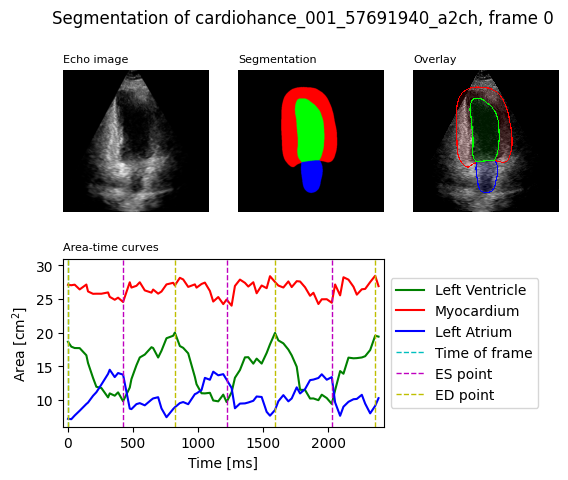

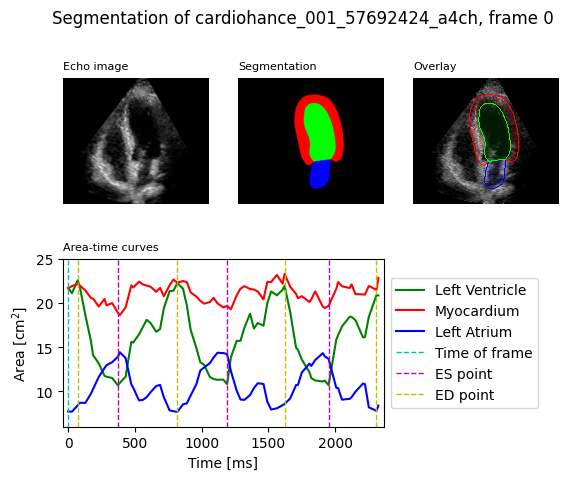

In [7]:
# Check if images are present. If not, do not plot the area-time curves. 
if len(os.listdir(path_to_images)) > 0:
    # Define the label colors as an RGB array
    colors_for_labels = np.array(
        [
            [0, 0, 0],    # label 0: black (background)
            [0, 255, 0],  # label 1: green (left ventricular cavity)
            [255, 0, 0],  # label 2: red (left ventricular myocardium)
            [0, 0, 255],  # label 3: blue (left atrium)
        ]
    )

    main_plot_area_time_curves(
        path_to_images,
        path_to_segmentations,
        all_files,
        views,
        dicom_properties,
        segmentation_properties,
        colors_for_labels,
    )

## Single-frame quality control, before post-processing. 
The single-frame QC is based on the following criteria:
* no missing structures for LV, MYO and LA
* no multiple structures for LV, MYO and LA
* no gap within LV, MYO, LA
* no gap between each structure

In [8]:
single_frame_qc_before_post_processing = main_single_frame_qc(
    path_to_segmentations, all_files, views
)

#### Get results of single-frame QC.

In [9]:
stats_single_frame_qc_before_post_processing = pd.DataFrame.from_dict(
    single_frame_qc_before_post_processing["stats"],
    orient="index",
    columns=["stats"],
)
stats_single_frame_qc_before_post_processing

,stats
missing_structure_lv,0
missing_structure_myo,0
missing_structure_la,0
duplicate_structures_lv,0
duplicate_structures_myo,0
duplicate_structures_la,0
holes_within_lv,0
holes_within_myo,0
holes_within_la,0
holes_between_lv_and_myo,0


## Do post-processing on faulthy segmentations.
The post-processing consists of the following steps:
* Determine the mean centroids of the LV<sub>cav</sub>, LV<sub>myo</sub>, and LA accross the entire image sequence. 
* Remove structures that do not contain the mean centroids. 
* Fill holes in the remaining structures.

In [10]:
main_post_processing(
    path_to_segmentations,
    path_to_final_segmentations,
    single_frame_qc_before_post_processing,
    all_files,
    views
)

#### Visualise the post-processing results.

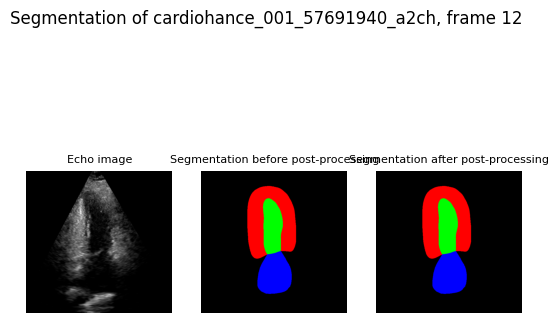

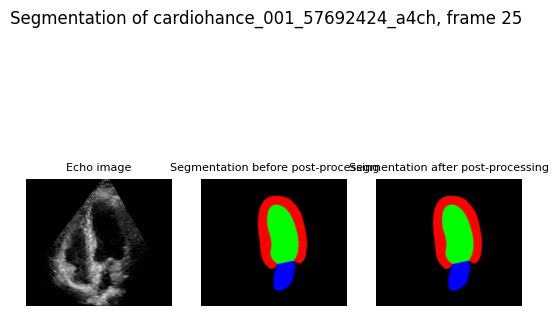

In [11]:
show_post_processing_results(path_to_images, path_to_segmentations, path_to_final_segmentations, all_files, views, single_frame_qc_before_post_processing, colors_for_labels)

## Single-frame quality control, after post-processing. 
The single-frame QC is repeated after post-processing, to see if the post-processing improved the segmentations. 

In [12]:
single_frame_qc_after_post_processing = main_single_frame_qc(
    path_to_final_segmentations, all_files, views
)

#### Get results of single-frame QC.

In [13]:
stats_single_frame_qc_after_post_processing = pd.DataFrame.from_dict(
    single_frame_qc_after_post_processing["stats"],
    orient="index",
    columns=["stats"],
)
stats_single_frame_qc_after_post_processing

,stats
missing_structure_lv,0
missing_structure_myo,0
missing_structure_la,0
duplicate_structures_lv,0
duplicate_structures_myo,0
duplicate_structures_la,0
holes_within_lv,0
holes_within_myo,0
holes_within_la,0
holes_between_lv_and_myo,0


## Multi-frame quality control based on structural criteria. 
This part of the multi-frame QC is based on the following criteria:
* LV<sub>cav</sub> should be fully surrounded by LV<sub>myo</sub> and LA.
* LA should be fully present in image plane, not cut off by image border.

In [14]:
multi_frame_qc_structural = main_multi_frame_qc_structural(
    path_to_segmentations, all_files, views
)

## Multi-frame quality control based on temporal criteria. 
This part of the multi-frame QC is based on the following criteria:
* The area-time curves of LV<sub>cav</sub> and LA are compared to reference curves by calculating the Dynamic Time Warping (DTW) distance.

#### Select the optimal cycle (cycle selection).
A DICOM file can contain images of multiple cardiac cycles. To be able to make a comparison between the reference curve and the area-time curves of the LV<sub>cav</sub> and LA of a specific image, the optimal cycle needs to be selected. The cycle selection is based on the following criteria:
* Number of flagged frames by single-frame QC.
* Number of flagged frames by multi-frame QC based on structural criteria.
* CNR between bloodpool (LV<sub>cav</sub> + LA) and LV<sub>myo</sub>.

In [15]:
cycle_information = main_cycle_selection(
    path_to_images,
    path_to_segmentations,
    segmentation_properties,
    single_frame_qc_after_post_processing,
    multi_frame_qc_structural,
    all_files,
    views,
)

Pre-defined or user-defined reference curves can be used. 
* Pre-defined curves were computed from our dataset of 182 participants (see paper for more details).
* User-defined curves can be computed from a different dataset (more information on this will be added soon). 

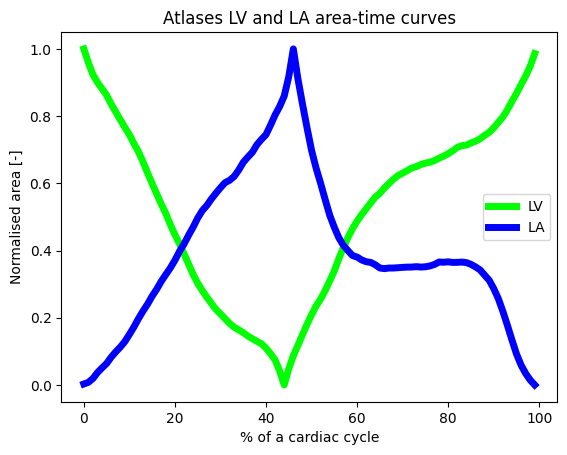

In [16]:
# Load pre-defined or user-defined atlases
if use_prev_defined_atlases:
    atlas_lv, atlas_la = load_atlases(os.path.join(path_to_atlases, "pre_defined"))

else:
    atlas_lv, atlas_la = load_atlases(os.path.join(path_to_atlases, "user_defined"))


show_atlases(atlas_lv, atlas_la)

#### Compute the Dynamic Time Warping distance between the area-time curves of the current patient and the atlases.

In [17]:
multi_frame_qc_temporal = main_multi_frame_qc_temporal(views, cycle_information, segmentation_properties, dicom_properties, atlas_lv, atlas_la)

## Multi-frame quality control combined.
#### Define criteria for exclusion by multi-frame QC. 

In [18]:
## Set criteria for multi-frame QC

# Image is flagged if the number of flagged frames in the selected cardiac cycle is higher or equal to the threshold.  
flagged_frame_threshold = 2

# Image is flagged if the DTW distance is larger than the threshold for either the left ventricle or left atrium.
dtw_threshold_lv = 1
dtw_threshold_la = 2
dtw_thresholds = [dtw_threshold_lv, dtw_threshold_la]

#### Determine whether or not to exclude the patient.

In [19]:
multi_frame_qc = main_multi_frame_qc(patient, views, cycle_information, multi_frame_qc_structural, multi_frame_qc_temporal, flagged_frame_threshold, dtw_thresholds)
multi_frame_qc["label_combined"]

{'Patient_0001': False}

## Calculate clinical indices. 
The following clinical indices are calculated:
* LV volumes in ED and ES (EDV, ESV)
* LV ejection fraction (EF)
* LV endocardial global longitudinal strain (GLS)
* LA maximum area

In [20]:
clinical_indices = main_computation_clinical_indices(path_to_segmentations, patient, views, all_files, cycle_information, dicom_properties, segmentation_properties)
show_clinical_indices(clinical_indices)

Indices                        Patient_0001                  
----------------------------------------
end_diastolic_volume_[ml]        51.0
end_systolic_volume_[ml]         15.6
ejection_fraction_[%]            69.4
global_long_strain_a2ch_[%]      24.6
maximum_la_area_a2ch_[mm2]       14.5
global_long_strain_a4ch_[%]      26.6
maximum_la_area_a4ch_[mm2]       14.3
----------------------------------------
